In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pysindy as ps
from pysindy.feature_library import PolynomialLibrary
from pysindy.differentiation import FiniteDifference
from mpl_toolkits import mplot3d
from scipy.optimize import curve_fit
from pysindy.feature_library import CustomLibrary
import math
import pysindy.feature_library
from scipy.signal import savgol_filter

In [1]:
!pip install pysindy # I needed this to use colab. You do not need to run this

In [2]:
!pip install --force-reinstall numpy==1.23.5 #needed for colab. You do not need to run

  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
bigframes 2.4.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, 

In [66]:
def logistic_growth_controlled(y, t, params, treatment_function, cycles):
    """
    Differential equation for logistic growth with a control term for Leukemic stem cells in active

    Args:
        y (float): Current population size.
        t (float): Current time.
        params (array float): array with parameter values.
        treatment_function : A function that takes time and cycles (t, cycle) and returns  u in {0,1}  ( 0 means no treatment and 1 treatment).
        cycles : treatment cycles

    Returns:
        float: The rate of change of the population size (dy/dt).
    """
    control = treatment_function(t,cycles)
    p_l, K_A, d_k, c = params
    dydt = ( p_l * (1 - y / K_A) - c*control -d_k ) * y
    # =p_l * y -(pl/KA)*y^2-c*control*y-dk*y=-(pl/KA)y^2+(pl-c*control-dk)*y
    return dydt

In [67]:
from google.colab import drive #this was for colab as well
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [68]:
## This is how we read the treatment data for a patient
def treatment_cycle( patient_id ) :

    #patient_id = 104
    # read all data.  [[ Boris ]] Its inefficient to read all data here; but we can optimize this later
    chemo_data = pd.read_csv('gdrive/My Drive/rsif20200091_si_003.csv')
    # get treatment information from a specific patient
    chemo_row = chemo_data[chemo_data.PatientID==patient_id].iloc[0]

    chemo_start_times = [int(x) for x in chemo_row['Chemo_begin'].split()] # starting times of therapy cycle
    chemo_end_times = [int(x) for x in chemo_row['Chemo_end'].split()] #

    return   [ chemo_start_times , chemo_end_times ]    ## [[ Boris ]] we may need a better data structure here


In [69]:
# Define a control function (example: constant control after a certain time)
def treatment_function(time, cycles ):

    chemo_start_times, chemo_end_times  = cycles

    Ncycles = len(chemo_start_times)

    for i in range(Ncycles) :
        if chemo_start_times[i] <= time <= chemo_end_times[i]  :
            return 1.0  # Apply 60% control

    return 0.0  # No control


## Run a Simulation

In [170]:
## Seting parameters for simulations
p_l = 0.11337807
K_A = 10000
d_k = 1/30
c = 1.2114013

# Initial value
La_o = 10000*.10

t = np.linspace(0, 500, 1000001) # Time points

discont=np.array([0,6,19,25,62,66,116,120,168,172]) #points where treatment turns on and off
epsilon=0.02
for point in discont:
  t = t[(t < point-epsilon) | (t > point+epsilon)] #remove a small range of time points around the discontinuity

print(t)



print(t.shape)

[2.050000e-02 2.100000e-02 2.150000e-02 ... 4.999990e+02 4.999995e+02
 5.000000e+02]
(999232,)


In [171]:
## Generate a trajectory with patient control

# determine treatment cycles
## This is how we read the treatment data for a patient
patient_id = 104
cycles = treatment_cycle( patient_id )

# names of the parameters to fit
params = [p_l, K_A, d_k, c]

results = odeint(logistic_growth_controlled, La_o , t, args=(params, treatment_function, cycles))
print(results)
print(results.shape[0])



[[1000.        ]
 [ 999.42881733]
 [ 998.85796366]
 ...
 [7059.1191025 ]
 [7059.11913711]
 [7059.11917172]]
999232


In [172]:
fd=FiniteDifference()
results_prime=fd._differentiate(results,t) #derivative does not include c, X'
print("The size of X' is ", results_prime.shape)

The size of X' is  (999232, 1)


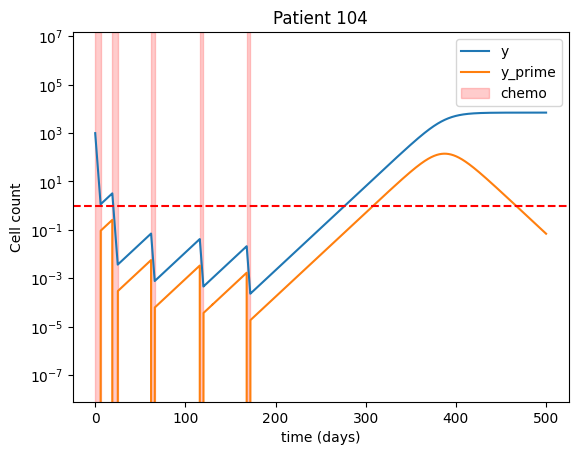

In [175]:
#plot the original trajectory and its derivative
fig, ax = plt.subplots()
chemo_start_times, chemo_end_times = cycles
plt.plot(t, results, label='y')
plt.plot(t, results_prime, label='y_prime')
plt.yscale('log')

for i, (start, end) in enumerate(zip(chemo_start_times, chemo_end_times)):
    label = None
    # the reason for the i=0 is so that we only have one thing in the legend, rather than a separate legend for every cycle.
    if i == 0:
        label = 'chemo'
    plt.fill_between([start, end], 0, 1, alpha=0.2, color='red',
                        label=label, transform=ax.get_xaxis_transform())

#results_smooth = savgol_filter(results, window_length=30, polyorder=11, axis=0) # window size 51, polynomial order 3
#plt.plot(t, results_smooth, label='y_smooth')


### Added This Part ###
plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.title(f'Patient {patient_id}')
plt.xlabel('time (days)')
plt.ylabel('Cell count')
plt.legend()
plt.show()

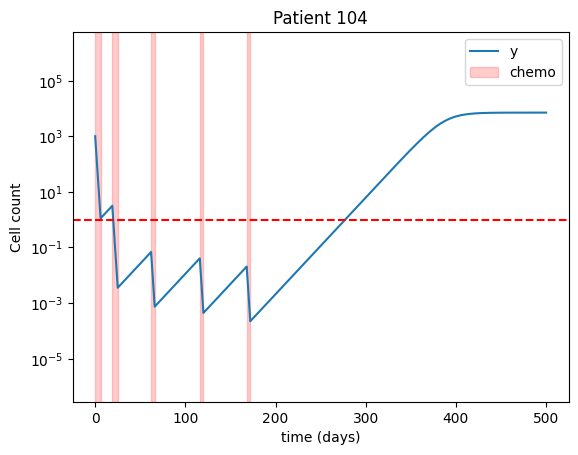

In [163]:
# plot a simple simulation
#original trajectory on its own

fig, ax = plt.subplots()
chemo_start_times, chemo_end_times = cycles
plt.plot(t, results, label='y')
plt.yscale('log')

for i, (start, end) in enumerate(zip(chemo_start_times, chemo_end_times)):
    label = None
    # the reason for the i=0 is so that we only have one thing in the legend, rather than a separate legend for every cycle.
    if i == 0:
        label = 'chemo'
    plt.fill_between([start, end], 0, 1, alpha=0.2, color='red',
                        label=label, transform=ax.get_xaxis_transform())

#results_smooth = savgol_filter(results, window_length=30, polyorder=11, axis=0) # window size 51, polynomial order 3
#plt.plot(t, results_smooth, label='y_smooth')


### Added This Part ###
plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.title(f'Patient {patient_id}')
plt.xlabel('time (days)')
plt.ylabel('Cell count')
plt.legend()
plt.show()


In [164]:
#using SINDy for one trajectory of hoffman

control_values=[]
num_rows,num_col=results.shape
print(num_rows)

for time in t:
      control_values.append(treatment_function(time,cycles)) #get the control values for each time point
print(results.shape)

results=np.array(results)
control_values=np.array(control_values)




#goal is to solve X'=Theta(X)*Xi for Xi


#data=results_smooth
#data_c=np.c_[results_smooth,control_values] #adds control_values as a second column

#print(control_values.shape)
#print(data_c.shape)

data=results
data_c=np.c_[results,control_values] #adds control_values as a second column

print(control_values.shape)
print(data_c.shape)

#Derivatives X'
fd=FiniteDifference()
data_prime=fd._differentiate(data,t) #derivative does not include c, X'
print("The size of X' is ", data_prime.shape)



#Libraries (Theta(X))
theta_lib_c=PolynomialLibrary(degree=2) #restrict to polynomials of deg 2
functions = [lambda x : x, lambda x : x*x, lambda x ,y : x*y]
customlib=CustomLibrary(library_functions=functions)

customlib.fit(data_c) #fit to our data
print(customlib.get_feature_names())
theta_c=customlib.transform(data_c) #transform to the correct size (,5)
print("The size of theta_c is", theta_c.shape)

#solve X'=Theta(X)*Xi for Xi
#use least squares solution as initial guess
Xi=np.linalg.lstsq(theta_c,data_prime)[0] #Is our initial guess using Python's least squares solver
print("Xi is ", Xi)

Xi_row,Xi_col=Xi.shape
print(Xi_row)
print(Xi_col)



Lambda=0.000000000001 #Sparsification knob (this was the value given in the PNAS paper for Lorenz)
            #This loop is adapted from the Sindy_PNAS paper, SI Appendix and converted into Python
for k in range(1000):
  smallinds=(np.absolute(Xi)<Lambda) #find all "very small" coefficients
               #print(smallinds)
  Xi[smallinds]=0 #set them=0
            #print(Eps_P)
  for ind in range(Xi_col): #Xi_col is the number of state variables
     biginds=np.logical_not(smallinds[:,ind]) #regress dynamics onto remaining terms
     Xi[biginds,ind]=np.linalg.lstsq(theta_c[:,biginds],data_prime[:,ind])[0]
print(Xi)

print(Xi.shape)

#print(results)

999991
(999991, 1)
(999991,)
(999991, 2)
The size of X' is  (999991, 1)
['f0(x0)', 'f0(x1)', 'f1(x0)', 'f1(x1)', 'f2(x0,x1)']
The size of theta_c is (999991, 5)
Xi is  [[ 8.00447377e-02]
 [ 9.73294069e-06]
 [-1.13378072e-05]
 [ 9.73294079e-06]
 [-1.21140138e+00]]
5
1


<__array_function__ internals>:180: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[ 8.00447377e-02]
 [ 9.73294069e-06]
 [-1.13378072e-05]
 [ 9.73294079e-06]
 [-1.21140138e+00]]
(5, 1)


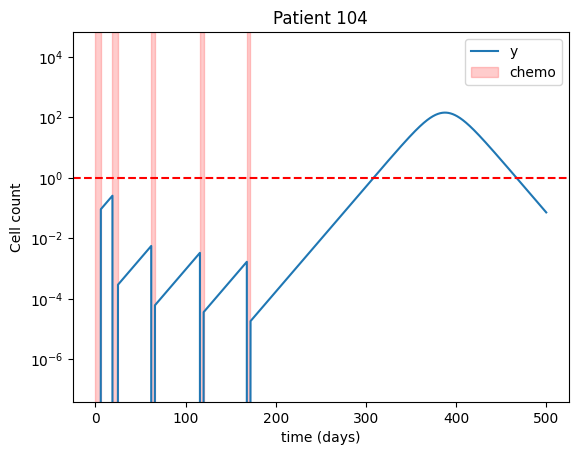

In [165]:
# plot a simple simulation

fig, ax = plt.subplots()
chemo_start_times, chemo_end_times = cycles
plt.plot(t, data_prime, label='y')
plt.yscale('log')

for i, (start, end) in enumerate(zip(chemo_start_times, chemo_end_times)):
    label = None
    # the reason for the i=0 is so that we only have one thing in the legend, rather than a separate legend for every cycle.
    if i == 0:
        label = 'chemo'
    plt.fill_between([start, end], 0, 1, alpha=0.2, color='red',
                        label=label, transform=ax.get_xaxis_transform())

#results_smooth = savgol_filter(results, window_length=30, polyorder=11, axis=0) # window size 51, polynomial order 3
#plt.plot(t, results_smooth, label='y_smooth')


### Added This Part ###
plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.title(f'Patient {patient_id}')
plt.xlabel('time (days)')
plt.ylabel('Cell count')
plt.legend()
plt.show()

In [166]:
print(theta_c)

[[1.00000000e+03 1.00000000e+00 1.00000000e+06 1.00000000e+00
  1.00000000e+03]
 [9.99428818e+02 1.00000000e+00 9.98857961e+05 1.00000000e+00
  9.99428818e+02]
 [9.98857965e+02 1.00000000e+00 9.97717233e+05 1.00000000e+00
  9.98857965e+02]
 ...
 [7.05909937e+03 0.00000000e+00 4.98308840e+07 0.00000000e+00
  0.00000000e+00]
 [7.05909941e+03 0.00000000e+00 4.98308845e+07 0.00000000e+00
  0.00000000e+00]
 [7.05909944e+03 0.00000000e+00 4.98308850e+07 0.00000000e+00
  0.00000000e+00]]


In [167]:
def recovered_model(y, t, params, treatment_function, cycles):
    """
    Differential equation for model recovered by SINDy

    Args:
        y (float): Current population size.
        t (float): Current time.
        params (array float): array with parameter values.


    Returns:
        float: The rate of change of the population size (dy/dt).
    """
    control = treatment_function(t,cycles)
    a0,a1,a2,a3,a4=params
    dydt = a0*y+a1*control+a2*y*y+a3*control*control+a4*y*control

    return dydt

In [168]:
a0=Xi[0]
a1=Xi[1]
a2=Xi[2]
a3=Xi[3]
a4=Xi[4]
params=[a0,a1,a2,a3,a4]
results_hat = odeint(recovered_model, La_o , t, args=(params,treatment_function,cycles))
print(results)
print(results_hat)
MSE = np.square(np.subtract(results[:,0],results_hat[:,0])).mean()
print(MSE)

[[1000.        ]
 [ 999.42881753]
 [ 998.85796451]
 ...
 [7059.09937371]
 [7059.09940912]
 [7059.09944452]]
[[1000.        ]
 [ 999.42881751]
 [ 998.85796445]
 ...
 [7059.20956028]
 [7059.20959127]
 [7059.20962226]]
3672.524839232037


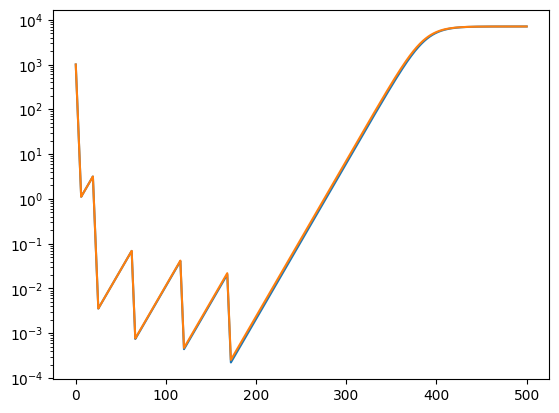

In [169]:
# plot a simple simulation
fig, ax = plt.subplots()
chemo_start_times, chemo_end_times = cycles
plt.plot(t, results, label='y')
plt.plot(t, results_hat, label='y_hat')
plt.yscale('log')

In [ ]:
# determine treatment cycles
cycles = [ [],[] ] # we provide empty treatment cycles

# names of the parameters to fit
params = [p_l, K_A, d_k, c]
## This is how we read the treatment data for a patient

results = odeint(logistic_growth_controlled, La_o , t, args=(params, treatment_function, cycles))

In [ ]:
#using SINDy for one trajectory of hoffman

control_values=[]
num_rows,num_col=results.shape
print(num_rows)

for time in t:
      control_values.append(treatment_function(time,cycles)) #get the control values for each time point
print(results.shape)

results=np.array(results)
control_values=np.array(control_values)




#goal is to solve X'=Theta(X)*Xi for Xi

#Data matrices (X) (one includes c, once does not)
#data_c=np.stack((results, control_values), axis=-1) # data includes control
data=results
data_c=np.c_[results,control_values] #adds control_values as a second column

print(control_values.shape)
print(data_c.shape)

#Derivatives X'
fd=FiniteDifference()
data_prime=fd._differentiate(results,t) #derivative does not include c, X'
print("The size of X' is ", data_prime.shape)



#Libraries (Theta(X))
theta_lib_c=PolynomialLibrary(degree=2) #restrict to polynomials of deg 2
functions = [lambda x : x, lambda x : x*x, lambda x ,y : x*y]
customlib=CustomLibrary(library_functions=functions)

customlib.fit(data_c) #fit to our data
print(customlib.get_feature_names())
theta_c=customlib.transform(data_c) #transform to the correct size (,5)
print("The size of theta_c is", theta_c.shape)

#solve X'=Theta(X)*Xi for Xi
#use least squares solution as initial guess
Xi=np.linalg.lstsq(theta_c,data_prime)[0] #Is our initial guess using Python's least squares solver
print("Xi is ", Xi)

Xi_row,Xi_col=Xi.shape
print(Xi_row)
print(Xi_col)



Lambda=0.000000000001 #Sparsification knob (this was the value given in the PNAS paper for Lorenz)
            #This loop is adapted from the Sindy_PNAS paper, SI Appendix and converted into Python
for k in range(1000):
  smallinds=(np.absolute(Xi)<Lambda) #find all "very small" coefficients
               #print(smallinds)
  Xi[smallinds]=0 #set them=0
            #print(Eps_P)
  for ind in range(Xi_col): #5 is the number of state variables
     biginds=np.logical_not(smallinds[:,ind]) #regress dynamics onto remaining terms
     Xi[biginds,ind]=np.linalg.lstsq(theta_c[:,biginds],data_prime[:,ind])[0]
print(Xi)

print(Xi.shape)

#print(results)

501
(501, 1)
(501,)
(501, 2)
The size of X' is  (501, 1)
['f0(x0)', 'f0(x1)', 'f1(x0)', 'f1(x1)', 'f2(x0,x1)']
The size of theta_c is (501, 5)
Xi is  [[ 8.00232952e-02]
 [ 0.00000000e+00]
 [-1.13347314e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
5
1
[[ 8.00232952e-02]
 [ 0.00000000e+00]
 [-1.13347314e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
(5, 1)


In [ ]:
a0=Xi[0]
a1=Xi[1]
a2=Xi[2]
a3=Xi[3]
a4=Xi[4]
params=[a0,a1,a2,a3,a4]
results_hat = odeint(recovered_model, La_o , t, args=(params,treatment_function,cycles))
print(results_hat)
MSE = np.square(np.subtract(results[:,0],results_hat[:,0])).mean()
print(MSE)

[[1000.        ]
 [1070.67765406]
 [1145.40648305]
 [1224.28491209]
 [1307.3945878 ]
 [1394.79763198]
 [1486.53394317]
 [1582.61823666]
 [1683.03767129]
 [1787.7492045 ]
 [1896.67744471]
 [2009.71277602]
 [2126.70994036]
 [2247.48710266]
 [2371.82561171]
 [2499.47030355]
 [2630.13060104]
 [2763.48233815]
 [2899.17033074]
 [3036.81167346]
 [3175.99970049]
 [3316.30862988]
 [3457.2985163 ]
 [3598.52090937]
 [3739.52422703]
 [3879.8597394 ]
 [4019.08724389]
 [4156.7804257 ]
 [4292.53199623]
 [4425.95828865]
 [4556.70325368]
 [4684.44176037]
 [4808.88220513]
 [4929.76835955]
 [5046.88046129]
 [5160.03560189]
 [5269.08744617]
 [5373.92535247]
 [5474.47291938]
 [5570.68619582]
 [5662.55140941]
 [5750.08261536]
 [5833.31889727]
 [5912.32179627]
 [5987.17241045]
 [6057.96871644]
 [6124.82292354]
 [6187.85887758]
 [6247.20976985]
 [6303.01584849]
 [6355.42247039]
 [6404.57825209]
 [6450.63347101]
 [6493.73864768]
 [6534.0433158 ]
 [6571.69497449]
 [6606.83824997]
 [6639.61408128]
 [6670.1592635

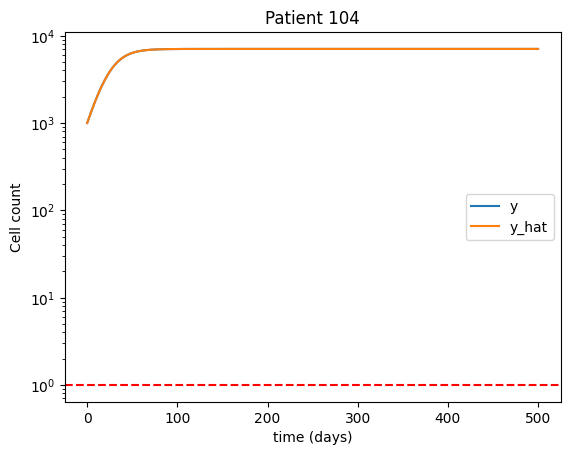

In [ ]:
# plot a simple simulation
fig, ax = plt.subplots()
chemo_start_times, chemo_end_times = cycles
plt.plot(t, results, label='y')
plt.plot(t, results_hat, label='y_hat')
plt.yscale('log')

for i, (start, end) in enumerate(zip(chemo_start_times, chemo_end_times)):
    label = None
    # the reason for the i=0 is so that we only have one thing in the legend, rather than a separate legend for every cycle.
    if i == 0:
        label = 'chemo'
    plt.fill_between([start, end], 0, 1, alpha=0.2, color='red',
                        label=label, transform=ax.get_xaxis_transform())
### Added This Part ###
plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.title(f'Patient {patient_id}')
plt.xlabel('time (days)')
plt.ylabel('Cell count')
plt.legend()
plt.show()